<h2>Расшифровка данных таблицы</h2>
<ol>
<li>Дата и время: Временной интервал в десять минут.</li>
<li>Температура: Температура погоды.</li>
<li>Влажность: Влажность воздуха.</li>
<li>Скорость ветра: Скорость ветра.</li>
<li>Общие сведения Диффузные потоки: “Диффузный поток” - это общий термин для описания низкотемпературных (от < 0,2° до ~ 100°C) флюидов, которые медленно вытекают через сульфидные насыпи, трещиноватые потоки лавы и скопления бактериальных матов и макрофауны.</li>
<li>Рассеянные потоки</li>
<li>Зона 1 Энергопотребления</li>
<li>Зона 2 энергопотребления</li>
<li>Зона 3 энергопотребления</li>
</ol>

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('/Users/ilya/Desktop/projects/TimeSeriesReasearch/powerconsumption.csv')
data.head()
# Преобразуем дату в формат datetime и установим индекс
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)
data_copy = data.drop(columns=['PowerConsumption_Zone2', 'PowerConsumption_Zone3'])
# Нормализуем данные
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['PowerConsumption_Zone1', 'PowerConsumption_Zone2']))

# Преобразуем обратно в DataFrame для удобства
scaled_data = pd.DataFrame(scaled_data, columns=data_copy.columns, index=data_copy.index)

# Разделим на входные признаки (X) и целевую переменную (y)
X = data_copy
y = data_copy['PowerConsumption_Zone1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [2]:
SEQ_LENGTH = 6
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
import random
from typing import TypedDict

import numpy as np
import torch
import torch.nn as nn
from torch.nn import Module, Parameter

class TiDEBatch(TypedDict):
    decoder_covariates: torch.Tensor  # (batch_size, horizon, covariates_size)
    encoder_covariates: torch.Tensor  # (batch_size, lookback, covariates_size)
    attributes: torch.Tensor  # (batch_size, attributes_size)
    decoder_target: torch.Tensor  # (batch_size, horizon, output_size)
    encoder_target: torch.Tensor  # (batch_size, lookback, output_size)


class ResidualBlock(Module):
    def __init__(
        self, hidden_size, input_size, output_size, p, layer_norm=True
    ) -> None:
        super().__init__()
        self.proj = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.hidden = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=p)
        if layer_norm:
            self.layer_norm = nn.LayerNorm(output_size)
        else:
            self.layer_norm = nn.Identity()
        self.proj_residual = nn.Linear(in_features=input_size, out_features=output_size)

    def forward(self, x):
        residual = self.proj_residual(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.proj(x)
        x = self.dropout(x)
        x = self.layer_norm(x + residual)
        return x


class ResidualSequenceBlock(Module):
    def __init__(
        self,
        n_blocks: int,
        hidden_size: int,
        input_size: int,
        output_size: int,
        p: float,
        layer_norm: bool,
    ) -> None:
        super().__init__()
        if n_blocks == 1:
            self.sequence = ResidualBlock(
                hidden_size=hidden_size,
                input_size=input_size,
                output_size=output_size,
                p=p,
                layer_norm=layer_norm
            )
        else:
            self.sequence = nn.Sequential(
                *(
                    [
                        ResidualBlock(
                            hidden_size=hidden_size,
                            input_size=input_size,
                            output_size=hidden_size,
                            p=p,
                            layer_norm=layer_norm
                        )
                    ]
                    + [
                        ResidualBlock(
                            hidden_size=hidden_size,
                            input_size=hidden_size,
                            output_size=hidden_size,
                            p=p,
                            layer_norm=layer_norm
                        )
                        for _ in range(n_blocks - 2)
                    ]
                    + [
                        ResidualBlock(
                            hidden_size=hidden_size,
                            input_size=hidden_size,
                            output_size=output_size,
                            p=p,
                            layer_norm=layer_norm
                        )
                    ]
                )
            )

    def forward(self, x):
        return self.sequence(x)


class TiDE(Module):
    def __init__(
        self,
        ne_blocks: int,
        nd_blocks,
        hidden_size: int,
        covariates_size: int,
        p: float,
        lookback: int,
        decoder_output_size: int,
        temporal_decoder_hidden_size: int,
        feature_projection_output_size: int,
        feature_projection_hidden_size: int,
        horizon: int,
        static_covariates_size: int,
        layer_norm: bool = True,
    ) -> None:
        super().__init__()

        self.feature_projection = ResidualBlock(
            input_size=covariates_size,
            output_size=feature_projection_output_size,
            hidden_size=feature_projection_hidden_size,
            p=p,
            layer_norm=layer_norm
        )

        self.temporal_decoder = ResidualBlock(
            input_size=decoder_output_size // horizon + feature_projection_output_size,
            output_size=1,
            hidden_size=temporal_decoder_hidden_size,
            p=p,
            layer_norm=layer_norm
        )
        self.residual_lookback_projection = nn.Linear(
            in_features=lookback, out_features=horizon
        )

        self.encoder = ResidualSequenceBlock(
            n_blocks=ne_blocks,
            p=p,
            input_size=lookback
            + static_covariates_size
            + feature_projection_output_size * lookback,
            output_size=hidden_size,
            hidden_size=hidden_size,
            layer_norm=layer_norm
        )

        self.decoder = ResidualSequenceBlock(
            n_blocks=nd_blocks,
            p=p,
            input_size=hidden_size,
            hidden_size=hidden_size,
            output_size=decoder_output_size,
            layer_norm=layer_norm
        )

    def forward(self, x: TiDEBatch) -> torch.Tensor:
        batch_size = x["encoder_covariates"].shape[0]
        horizon = x["decoder_covariates"].shape[1]

        encoder_covariates = x["encoder_covariates"]
        decoder_covariates = x["decoder_covariates"]
        attributes = x["attributes"]
        encoder_target = x["encoder_target"]

        encoder_feature_projection = self.feature_projection(encoder_covariates)
        decoder_feature_projection = self.feature_projection(decoder_covariates)

        history = torch.cat(
            [
                encoder_target.reshape(batch_size, -1),
                attributes,
                encoder_feature_projection.reshape(batch_size, -1),
            ],
            dim=-1,
        )

        encoded_history = self.encoder(history)
        decoded_history = self.decoder(encoded_history)

        temporal_decoder_input = torch.cat(
            [
                decoded_history.reshape(batch_size, horizon, -1),
                decoder_feature_projection,
            ],
            dim=-1,
        )

        temporal_decoder_projection = self.temporal_decoder(temporal_decoder_input)

        residual_lookback_projection = self.residual_lookback_projection(
            encoder_target.reshape(batch_size, -1)
        ).reshape(batch_size, horizon, -1)

        y_hat = residual_lookback_projection + temporal_decoder_projection

        return y_hat

In [85]:
def prepare_tide_batch(X, y, lookback, horizon, batch_size):
    """
    Подготовка данных для TiDE.
    Args:
        X: numpy.ndarray, ковариаты (входные признаки)
        y: numpy.ndarray, целевые значения
        lookback: int, длина окна для энкодера
        horizon: int, длина прогноза
        batch_size: int, размер батча
    Returns:
        List[TiDEBatch]: список батчей в формате TiDEBatch
    """
    num_batches = (len(X) - lookback - horizon) // batch_size
    batches = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        encoder_covariates = [
            X[j : j + lookback] for j in range(start_idx, end_idx)
        ]  # (batch_size, lookback, covariates_size)
        decoder_covariates = [
            X[j + lookback : j + lookback + horizon] for j in range(start_idx, end_idx)
        ]  # (batch_size, horizon, covariates_size)
        encoder_target = [
            y[j : j + lookback] for j in range(start_idx, end_idx)
        ]  # (batch_size, lookback, output_size)
        decoder_target = [
            y[j + lookback : j + lookback + horizon] for j in range(start_idx, end_idx)
        ]  # (batch_size, horizon, output_size)

        # Пример статических атрибутов (если отсутствуют, можно заполнить нулями)
        attributes = np.zeros((batch_size, 1))  # (batch_size, attributes_size)

        batches.append(
            {
                "decoder_covariates": torch.tensor(decoder_covariates, dtype=torch.float32),
                "encoder_covariates": torch.tensor(encoder_covariates, dtype=torch.float32),
                "attributes": torch.tensor(attributes, dtype=torch.float32),
                "decoder_target": torch.tensor(decoder_target, dtype=torch.float32),
                "encoder_target": torch.tensor(encoder_target, dtype=torch.float32),
            }
        )

    return batches


In [98]:
horizon = 144
lookback = 1440

train_batches = prepare_tide_batch(X_train.values, y_train.values, lookback, horizon, 12)
test_batches = prepare_tide_batch(X_test.values, y_test.values, lookback, horizon, 12)


In [99]:
model = TiDE(
    ne_blocks=3,
    nd_blocks=3,
    hidden_size=64,
    covariates_size=X_train.shape[1],  # Размерность encoder/decoder_covariates
    p=0.1,
    lookback=lookback,
    decoder_output_size=144,
    temporal_decoder_hidden_size=144,
    feature_projection_output_size=72,
    feature_projection_hidden_size=144,
    horizon=horizon,
    static_covariates_size=1,  # Исправлено на соответствие с shape attributes
    layer_norm=True
)

In [100]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [102]:
from tqdm import tqdm
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for batch in tqdm(train_batches):  # `train_batches` - список TiDEBatch из функции prepare_tide_batch
        batch = {key: value.to(DEVICE) for key, value in batch.items()}  # Перемещение на устройство
        
        optimizer.zero_grad()
        y_pred = model(batch)  # Получаем предсказания
        loss = criterion(y_pred.squeeze(), batch["decoder_target"].squeeze())  # Считаем ошибку
        loss.backward()  # Обратное распространение
        optimizer.step()  # Обновление весов
        
        train_loss += loss.item()

    train_loss /= len(train_batches)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}")

100%|██████████| 3362/3362 [02:08<00:00, 26.16it/s]


Epoch 1/10, Loss: 784856427.9170


100%|██████████| 3362/3362 [02:10<00:00, 25.78it/s]


Epoch 2/10, Loss: 843520719.2118


100%|██████████| 3362/3362 [02:09<00:00, 26.04it/s]


Epoch 3/10, Loss: 832608594.1095


  5%|▌         | 177/3362 [00:06<02:04, 25.49it/s]


KeyboardInterrupt: 

In [103]:
# Получение предсказаний
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch in test_batches:  # `test_batches` - список TiDEBatch из тестовых данных
        batch = {key: value.to(DEVICE) for key, value in batch.items()}  # Перемещение на устройство
        y_pred = model(batch)  # Предсказания
        predictions.append(y_pred.cpu().numpy())  # Перемещение на CPU для обработки
        actuals.append(batch["decoder_target"].cpu().numpy())

# Преобразование предсказаний и истинных значений в массивы
all_preds = np.concatenate(predictions, axis=0).squeeze()  # (все батчи объединяются)
all_true = np.concatenate(actuals, axis=0).squeeze()


In [104]:
# if predictions.ndim == 1:
#     all_preds = all_preds[:, np.newaxis]  # Добавляем размерность, если нужно
# if actuals.ndim == 1:
#     all_true = all_true[:, np.newaxis]

# Обратное масштабирование для предсказаний
# all_preds= scaler.inverse_transform(
#     np.concatenate([np.zeros((all_preds.shape[0], scaled_data.shape[1] - 1)), all_preds], axis=1)
# )[:, -1]  # берем колонку с предсказаниями

# # Обратное масштабирование для истинных значений
# all_true = scaler.inverse_transform(
#     np.concatenate([np.zeros((all_true.shape[0], scaled_data.shape[1] - 1)), all_true.reshape(-1, 1)], axis=1)
# )[:, -1]  # берем колонку с истинными значениями

# Оценка модели
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))
mape = mean_absolute_error(all_true, all_preds)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")


MSE: 715923712.0000
RMSE: 26756.7500
MAPE: 20979.3711


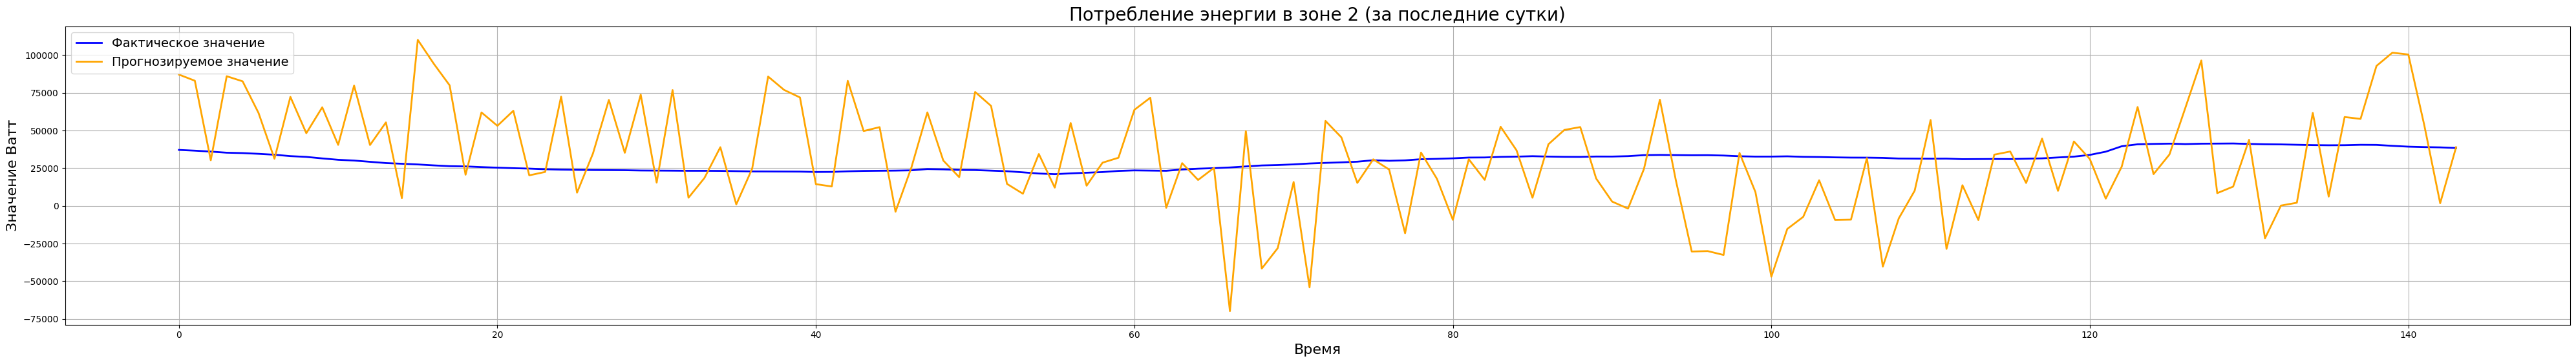

In [110]:
plt.figure(figsize=(50, 6))
plt.plot(range(len(all_true[100])), all_true[100], label='Фактическое значение', color='blue', linewidth=2)
plt.plot(range(len(all_preds[100])), all_preds[100], label='Прогнозируемое значение', color='orange', linewidth=2)

# Подписи
plt.title("Потребление энергии в зоне 2 (за последние сутки)", fontsize=20)
plt.xlabel("Время", fontsize=16)
plt.ylabel("Значение Ватт", fontsize=16)

# Легенда
plt.legend(fontsize=14)

# Сетка для удобства анализа
plt.grid(True)

plt.show()
